# Code for figure 2 (sensitivity and degeneracy plots)

In [6]:
import os
from pathlib import Path
import pickle
from tqdm.auto import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import torch
import torch.nn as nn

from deep_ei import topology_of, ei_of_layer, sensitivity_of_layer

## Set colormaps

In [2]:
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(1.0 * pos / size)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

## Set device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


## Let's first confirm that the sensitivity plot is identical to the EI plot for A -> B networks:

In [4]:
sensitivity_of_layer?

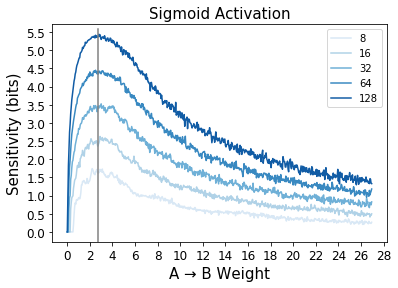

In [5]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    sens = []
    for w in ws:
        singleton.weight.data[0][0] = w
        sensitivity = sensitivity_of_layer(singleton, top, 
                                           samples=1000, 
                                           batch_size=500,  
                                           in_range=(0, 1),
                                           in_bins=binSize,
                                           out_range=(0, 1),
                                           out_bins=binSize,
                                           activation=nn.Sigmoid(), 
                                           device=device)
        sens.append(sensitivity)
    ax.plot(ws, sens, color=color, label=str(binSize))
    
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

ax.set_title("Sigmoid Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Sensitivity (bits)',fontsize=15)
plt.legend()

# plt.savefig("figures/sensitivity/sensitivity-sigmoid-1d-blue", dpi=300, bbox_inches='tight')

## Okay looks good... let's proceed with an A, B -> C example

## First generate the ei and sensitivity data

In [8]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    ei = ei_of_layer(tiny_network, top, 
                     samples=10000, 
                     batch_size=500, 
                     in_range=(0, 1), 
                     in_bins=bins,
                     out_range=(0, 1), 
                     out_bins=bins,
                     activation=nn.Sigmoid(), 
                     device=device)
    eis.append(ei)
    
zs = np.array(eis)
eis = zs.reshape(X.shape)

sens = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    sen = sensitivity_of_layer(tiny_network, top, 
                               samples=10000, 
                               batch_size=500,
                               in_range=(0, 1),
                               in_bins=bins,
                               out_range=(0, 1),
                               out_bins=bins,
                               activation=nn.Sigmoid(),
                               device=device)
    sens.append(sen)
    
zs = np.array(sens)
sens = zs.reshape(X.shape)

## And now let's plot it:

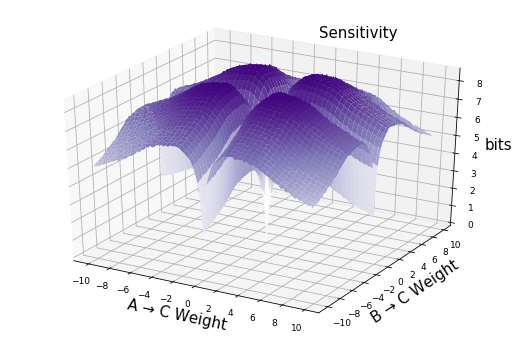

In [17]:
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, sens, cmap=plt.cm.Purples, label="sensitivity")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Sensitivity", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('bits', fontsize=15)
ax.set_zlim(0, 8.5)

plt.savefig("figures/sensitivity-sigmoid-2d", dpi=300, bbox_inches='tight')

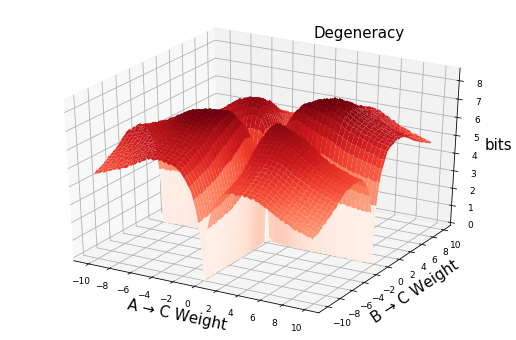

In [19]:
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, sens-eis, cmap=plt.cm.Reds, label="degeneracy")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Degeneracy", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('bits', fontsize=15)
ax.set_zlim(0, 8.5)

plt.savefig("figures/degeneracy-sigmoid-2d", dpi=300, bbox_inches='tight')

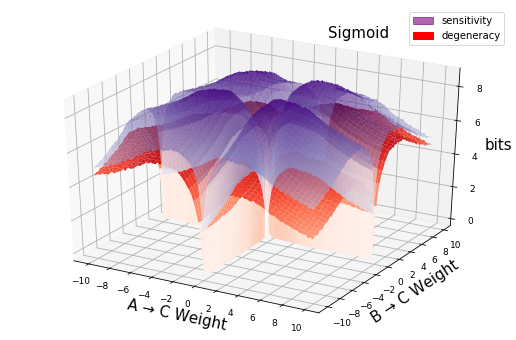

In [10]:
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, sens, cmap=plt.cm.Purples, label="sensitivity", alpha=0.6)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(X, Y, sens-eis, cmap=plt.cm.Reds, label="degeneracy", alpha=1.0)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d


size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Sigmoid", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('bits', fontsize=15)

# ax.view_init(elev=9)

ax.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('purple')
leg.legendHandles[1].set_color('red')

# plt.savefig("figures/sensitivity/sensitivity-and-degeneracy-sigmoid-2d", dpi=300, bbox_inches='tight')

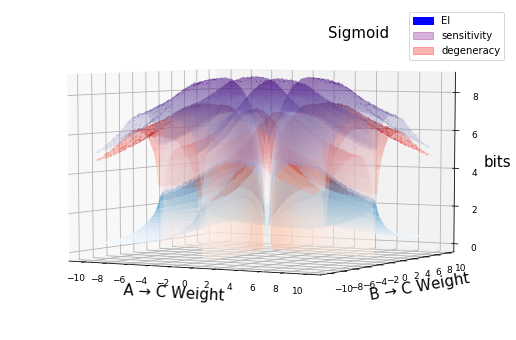

In [11]:
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, eis, cmap=plt.cm.Blues, label="EI")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(X, Y, sens, cmap=plt.cm.Purples, label="sensitivity", alpha=0.3)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

surf = ax.plot_surface(X, Y, sens-eis, cmap=plt.cm.Reds, label="degeneracy", alpha=0.3)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d


size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Sigmoid", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('bits', fontsize=15)

ax.view_init(elev=5)

ax.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('purple')
leg.legendHandles[2].set_color('red')

# plt.savefig("figures/sensitivity/all-three-sigmoid-lower-angle-2d", dpi=300, bbox_inches='tight')